In [1]:
basedir = '/home/abhinavgupta0110/generalized_nCM'

import os

is_google_colab = False
is_use_GPU = False

In [2]:
if is_use_GPU:
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('No GPU found!')
    else:
        print(gpu_info)

if is_google_colab:
    from google.colab import drive
    drive.mount('/content/drive')

    %pip install quadpy

os.chdir(os.path.join(basedir, 'generalized_nCMs'))

%load_ext autoreload

In [3]:
%autoreload 2

from src.utilities.DDE_Solver import ddeinttf 
from src.bio_eqn_case.bio_Eqn_Helper_Classes import * 
import src.bio_eqn_case.bio_eqn as bio
import src.utilities.findiff.findiff_general as fdgen

import time
from math import *
from IPython.core.debugger import set_trace

import numpy as np
import scipy.interpolate
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm

tf.keras.backend.set_floatx('float32')

In [4]:
class temperature_func:
    def __init__(self, T_top, T_bot, z_max):
        self.T_top = T_top
        self.T_bot = T_bot
        self.z_max = z_max
        
    def __call__(self, z, t):
        A = self.T_top
        K = self.T_bot
        C = 1
        Q = 0.5
        B = 0.25
        nu = 2.0
        T = lambda x: A + ((K - A) / (C + Q * np.exp(-B*x))**(1./nu))
        
        T = np.stack([ T(np.abs(z) + self.z_max/2) for i in range(t.shape[0])], axis=0)
        
        return T

## NPZD Model

In [5]:
sec_to_day = 1./(60*60*24)

args = bio.bio_eqn_args(T = 365, nt = 365, nz = 20, z_max = -100, a = 0.07, g_max = 0.81e-5 / sec_to_day, k_P = 0.06, k_D = 0.01, 
                        k_W = 0.08, K_N = 0.5, K_P = 0.25, m_p = 9.26e-7 / sec_to_day, m_z = 6.94e-7 / sec_to_day, 
                        T_opt = 20, mu_max = 3.25e-5 / sec_to_day, alpha = 1.62e-6 / sec_to_day, beta = 3.24e-8 / sec_to_day, 
                        epsilon = 1.736e-7 / sec_to_day, lamb = 0.3, gamma = 0.4, C_P = 6.625, C_Z = 5.625, C_D = 7.5, gamma_c = 0.0001, T_bio_min = 10, T_bio_max = 20, 
                        bio_model = 'NPZ-OA', Temp = temperature_func(20, 20, -100), Salt = None, extra_terms=1, skip_bnd = 0)

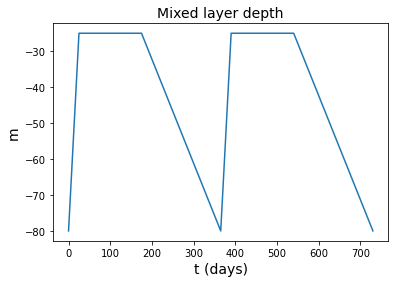

In [6]:
t_M = np.array([0, 25, 175, 365, 365 + 25, 365 + 175, 365+365])
M = np.array([-80., -25., -25., -80., -25., -25., -80])

fig, ax = plt.subplots()
ax.plot(t_M, M)
ax.set_title('Mixed layer depth', fontsize=14)
ax.set_ylabel('m', fontsize=14)
ax.set_xlabel('t (days)', fontsize=14)

K_z_obj = diff_coeff(args, M, t_M, 'linear')

In [7]:
t = tf.linspace(0., args.T, args.nt) # Time array

Text(0.5, 0, 't (days)')

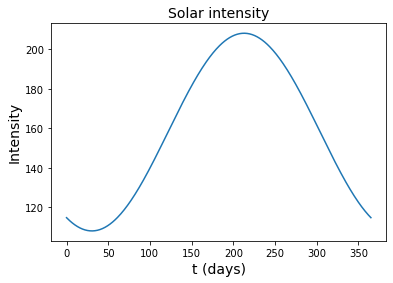

In [8]:
fig, ax = plt.subplots()
ax.plot(t, args.I_0_t(t))
ax.set_title('Solar intensity', fontsize=14)
ax.set_ylabel('Intensity', fontsize=14)
ax.set_xlabel('t (days)', fontsize=14)

Text(0, 0.5, 'z (m)')

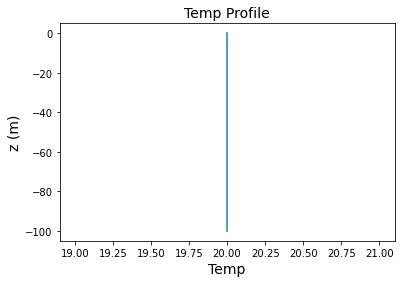

In [9]:
fig, ax = plt.subplots()
ax.plot(args.Temp(args.z, np.array([0.]))[0,:], args.z)
ax.set_title('Temp Profile', fontsize=14)
ax.set_xlabel('Temp', fontsize=14)
ax.set_ylabel('z (m)', fontsize=14)

In [10]:
class initial_cond:

    def __init__(self, app):
        self.app = app

    def __call__(self, t):

        if self.app.bio_model == 'NPZD-OA':
            x0 = [self.app.T_bio - 3*0.05*self.app.T_bio, 0.05*self.app.T_bio, 0.05*self.app.T_bio, 0.05*self.app.T_bio]
            
        if self.app.bio_model == 'NPZ-OA':
            x0 = [self.app.T_bio - 2*0.05*self.app.T_bio, 0.05*self.app.T_bio, 0.05*self.app.T_bio]
        return tf.expand_dims(tf.concat(x0, axis=0), axis=0)

In [11]:
x0_low_complex = initial_cond(args)

In [12]:
x_npz_pre = ddeinttf(bio.bio_eqn(args, K_z_obj).initial_cond_solve, x0_low_complex, tf.linspace(0., 30, 30), alg_name = 'dopri5', nsteps = 100)

In [13]:
class custom_plot:

    def __init__(self, z, t, args):
        self.t = t
        self.args = args
        self.T, self.Z = np.meshgrid(t.numpy(), z.numpy())
        self.z = z
        
    def plot_indiv(self, ax, title, B):
        ax.cla()
        ax.set_title(title, fontsize=14)
        ax.set_ylabel('z', fontsize=14)
        ax.set_xlabel('t (days)', fontsize=14)
        plot = ax.contourf(self.T, self.Z, B, cmap=cm.coolwarm,
                           antialiased=False, levels=np.linspace(0, np.max(B.flatten()), 20), extend='min')
        ax.set_ylim(self.z[-1], self.z[0])
        ax.set_xlim(self.t[0], self.t[-1])
        plt.colorbar(plot, ax=ax, shrink=0.5, aspect=10)
        
            
    def plot_npzd(self, B):
        fig = plt.figure(figsize=(14, 10), facecolor='white')
        ax_N = fig.add_subplot(221)
        ax_P = fig.add_subplot(222)
        ax_Z = fig.add_subplot(223)
        ax_D = fig.add_subplot(224)
        
        self.plot_indiv(ax_N, 'Nutrients', tf.transpose(tf.squeeze(B[:, :, 0:self.args.nz], axis=1)).numpy())
        self.plot_indiv(ax_P, 'Phytoplankton', tf.transpose(tf.squeeze(B[:, :, self.args.nz:2*self.args.nz], axis=1)).numpy())
        self.plot_indiv(ax_Z, 'Zooplankton', tf.transpose(tf.squeeze(B[:, :, 2*self.args.nz:3*self.args.nz], axis=1)).numpy())
        self.plot_indiv(ax_D, 'Detritus', tf.transpose(tf.squeeze(B[:, :, 3*self.args.nz:4*self.args.nz], axis=1)).numpy())

        plt.show()
        
    def plot_npz(self, B):
        fig = plt.figure(figsize=(14, 10), facecolor='white')
        ax_N = fig.add_subplot(221)
        ax_P = fig.add_subplot(222)
        ax_Z = fig.add_subplot(223)
#         ax_D = fig.add_subplot(224)
        
        self.plot_indiv(ax_N, 'Nutrients', tf.transpose(tf.squeeze(B[:, :, 0:self.args.nz], axis=1)).numpy())
        self.plot_indiv(ax_P, 'Phytoplankton', tf.transpose(tf.squeeze(B[:, :, self.args.nz:2*self.args.nz], axis=1)).numpy())
        self.plot_indiv(ax_Z, 'Zooplankton', tf.transpose(tf.squeeze(B[:, :, 2*self.args.nz:3*self.args.nz], axis=1)).numpy())
#         self.plot_indiv(ax_D, 'Detritus', tf.transpose(tf.squeeze(B[:, :, 3*self.args.nz:4*self.args.nz], axis=1)).numpy())

        plt.show()
        
    def plot_npzd_oa(self, B):
        fig = plt.figure(figsize=(15, 20), facecolor='white')
        ax_N = fig.add_subplot(321)
        ax_P = fig.add_subplot(322)
        ax_Z = fig.add_subplot(323)
        ax_D = fig.add_subplot(324)
        ax_DIC = fig.add_subplot(325)
        ax_TA = fig.add_subplot(326)
        
        self.plot_indiv(ax_N, 'Nutrients', tf.transpose(tf.squeeze(B[:, :, 0*self.args.nz:1*self.args.nz], axis=1)).numpy())
        self.plot_indiv(ax_P, 'Phytoplankton', tf.transpose(tf.squeeze(B[:, :, 1*self.args.nz:2*self.args.nz], axis=1)).numpy())
        self.plot_indiv(ax_Z, 'Zooplankton', tf.transpose(tf.squeeze(B[:, :, 2*self.args.nz:3*self.args.nz], axis=1)).numpy())
        self.plot_indiv(ax_D, 'Detritus', tf.transpose(tf.squeeze(B[:, :, 3*self.args.nz:4*self.args.nz], axis=1)).numpy())
        self.plot_indiv(ax_DIC, 'DIC', tf.transpose(tf.squeeze(B[:, :, 4*self.args.nz:5*self.args.nz], axis=1)).numpy())
        self.plot_indiv(ax_TA, 'Total Alkalinity', tf.transpose(tf.squeeze(B[:, :, 5*self.args.nz:6*self.args.nz], axis=1)).numpy())

        plt.show()
        
    def plot_npz_oa(self, B):
        fig = plt.figure(figsize=(15, 20), facecolor='white')
        ax_N = fig.add_subplot(321)
        ax_P = fig.add_subplot(322)
        ax_Z = fig.add_subplot(323)
#         ax_D = fig.add_subplot(324)
        ax_DIC = fig.add_subplot(325)
        ax_TA = fig.add_subplot(326)
        
        self.plot_indiv(ax_N, 'Nutrients', tf.transpose(tf.squeeze(B[:, :, 0*self.args.nz:1*self.args.nz], axis=1)).numpy())
        self.plot_indiv(ax_P, 'Phytoplankton', tf.transpose(tf.squeeze(B[:, :, 1*self.args.nz:2*self.args.nz], axis=1)).numpy())
        self.plot_indiv(ax_Z, 'Zooplankton', tf.transpose(tf.squeeze(B[:, :, 2*self.args.nz:3*self.args.nz], axis=1)).numpy())
#         self.plot_indiv(ax_D, 'Detritus', tf.transpose(tf.squeeze(B[:, :, 3*self.args.nz:4*self.args.nz], axis=1)).numpy())
        self.plot_indiv(ax_DIC, 'DIC', tf.transpose(tf.squeeze(B[:, :, 3*self.args.nz:4*self.args.nz], axis=1)).numpy())
        self.plot_indiv(ax_TA, 'Total Alkalinity', tf.transpose(tf.squeeze(B[:, :, 4*self.args.nz:5*self.args.nz], axis=1)).numpy())

        plt.show()

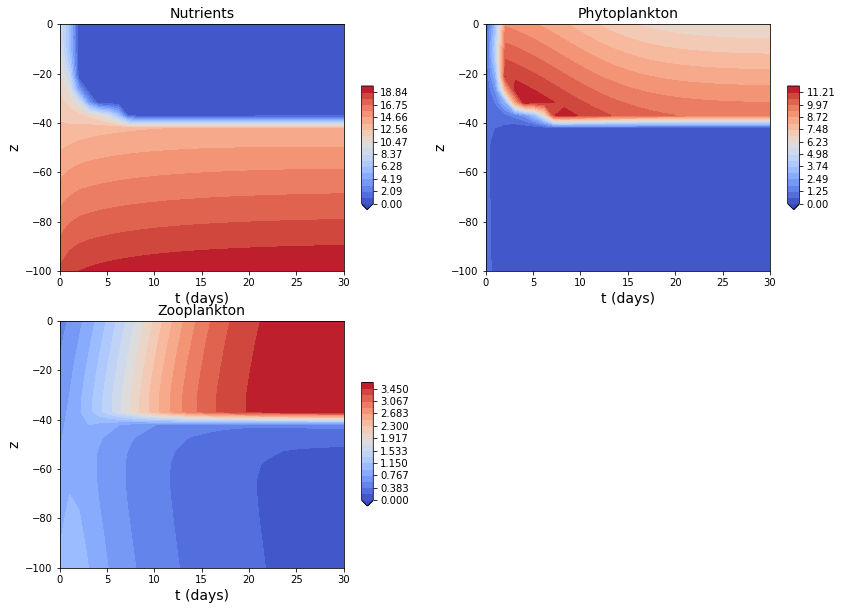

In [14]:
custom_plot(args.z, tf.linspace(0., 30, 30), args).plot_npz(x_npz_pre)

In [15]:
class initial_cond_reuse:

    def __init__(self, app, x0, sal_prof):
        self.app = app
        self.x0 = x0
        self.sal_prof = sal_prof

    def __call__(self, t):

#         OA_0 = [self.app.C_P * self.x0[:, 1*self.app.nz:2*self.app.nz] + self.app.C_Z * self.x0[:, 2*self.app.nz:3*self.app.nz] + self.app.C_D * self.x0[:, 3*self.app.nz:4*self.app.nz], (198.10 + 61.75 * self.sal_prof) / 1000.]
        OA_0 = [self.app.C_P * self.x0[:, 0*self.app.nz:1*self.app.nz], (198.10 + 61.75 * self.sal_prof) / 1000.]
#         OA_0 = [self.app.C_P * self.x0[:, 0*self.app.nz:1*self.app.nz], self.x0[:, 0*self.app.nz:1*self.app.nz]]
        
        return tf.concat([self.x0] + OA_0, axis=-1)

In [16]:
new_init = initial_cond_reuse(args, x_npz_pre[-1, :], temperature_func(31.4, 32.8, -100)(args.z, np.array([0.])))

In [17]:
grid_obj = fdgen.grid(args, args.z)
deriv_obj = fdgen.deriv(args, grid_obj)

In [18]:
x_npz = ddeinttf(bio.bio_eqn(args, K_z_obj, grid_obj, deriv_obj), new_init, t, alg_name = 'dopri5', nsteps = 100)

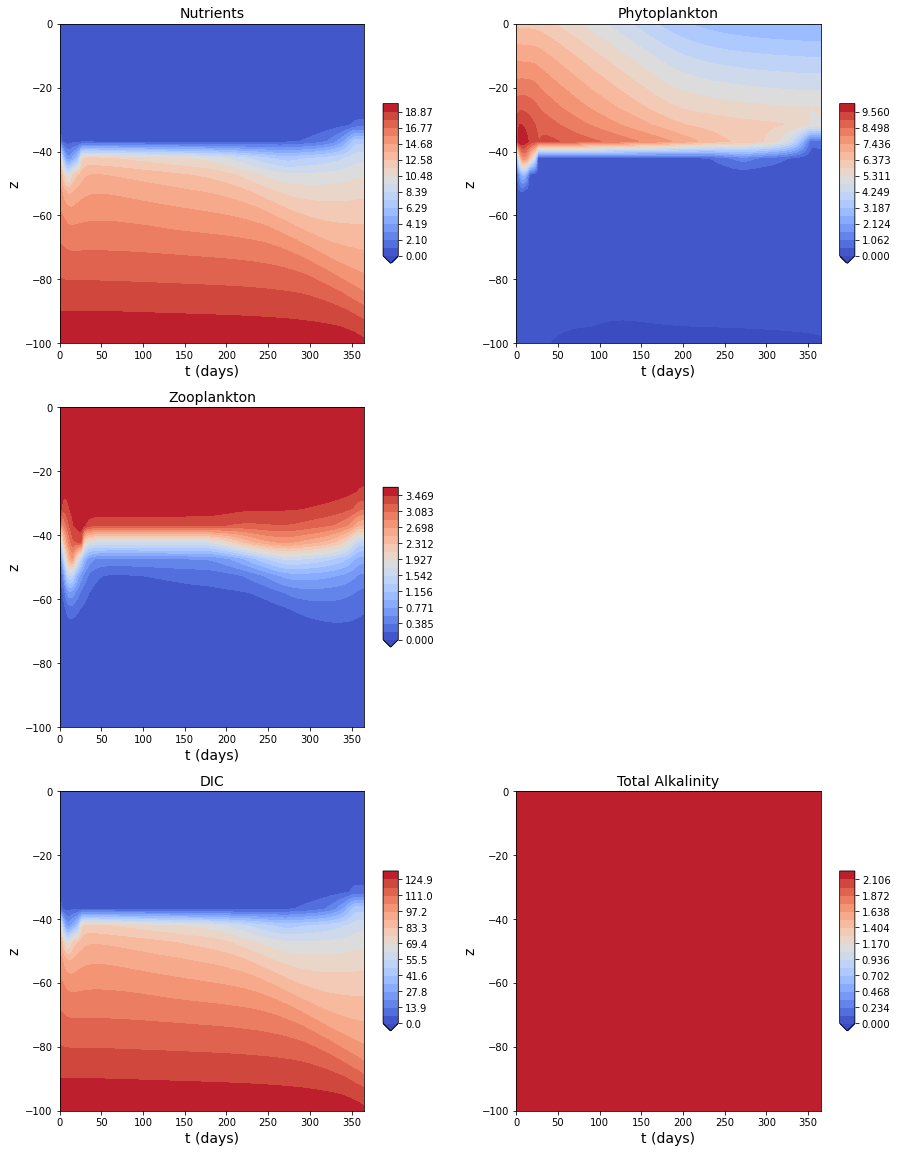

In [19]:
custom_plot(args.z, t, args).plot_npz_oa(x_npz)